<a href="https://colab.research.google.com/github/JuliethLopez/chatbot_simpsons/blob/master/Modelo_de_Clasificacion_ngrams_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de texto 

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Con éste código se pretende clasificar un conjunto de frases utilizadas en los dialogos de los simpsons a través de clasificadores de textos de lenguaje natural automáticos. La librería usual para trabajar con datos de lenguaje humano es ntkl, que es la biblioteca más utilizada para interactuar con la utilización del lenguaje natural.

In [77]:
# Librerias
import re 
import csv
import nltk
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.util import ngrams
from tensorflow.keras import layers
from nltk.tokenize import regexp_tokenize
from tensorflow.keras import regularizers
from sklearn. preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.utils import to_categorical, plot_model

# Define algunas características iniciales

Aquí establecemos la proporción de datos a entrenar, que va a corresponder al 80% del total de los datos. También definimos un arreglo con los caracteres que se desea, representen a los datos de nuestra base. Eliminando así cualquier caracter de uso poco frecuente.

In [3]:
training_portion = 0.8  
oov_tok = "<OOV>" 

In [4]:
a = np.array([32]) # space
c = np.array(range(97,123)) 
printab = np.hstack((a,c))
printable = np.array([chr(i) for i in printab])   
printable 

array([' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
       'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
       'z'], dtype='<U1')

# Lectura de los datos

La base de datos correspondiente para esta parte del trabajo se consigue con el nombre de "Dialogue Lines of The Simpsons" la cual puede ser consultada en la página de libre acceso kaggle. En principio, éste conjunto de datos contiene personajes, ubicaciones, detalles de los episodios y las líneas de guión de aproximadamente 600 episodios de Simpson, que datan de 1989. Sin embargo, para propositos de esta parte del trabajo la base de datos fue filtrada en excel y se hizo uso únicamente de las columnas "Name of the character who speaks" y "Actual text spoken".

In [5]:
complete_lines = [] 
sentences = []
labels = [] 

In [6]:
# abre el archivo de datos y lo trata como un archivo csv
#file = open('/content/drive/My Drive/Colab Notebooks/DFSMS.csv', 'r') #David
#file = open('/content/drive/My Drive/Simpsons Chat bot/chatbot_simpsons-master/Datos/DFSMS.csv', 'r') #Julieth
file = open('DFSMS.csv', 'r') #Juan
with file as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        # preprocess label
        #label_l = ' '.join(row[0].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
        label_l = re.sub(' +', ' ',row[0].lower()) # lower case ans eliminate multiple spaces
        if (len(label_l)>2): # drop with empty label
            label = ''.join(c for c in label_l if c in printable)# filter only printable characters
            label = label.replace(' ','_')
            labels.append(label)
            # preprocess sentence
            #sentence_l = ' '.join(row[1].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
            sentence_l = re.sub(' +', ' ',row[1].lower())
            sentence = ''.join(c for c in sentence_l if c in printable)
            complete_lines.append(row[0] + ': '+ row[1])
            sentences.append(sentence)
 

# resumen de la lectura            
print("labels:",len(labels))
print("complete_lines:",len(complete_lines))
print("sentences",len(sentences))

labels: 64773
complete_lines: 64773
sentences 64773


In [7]:
# Tercer linea
print(labels[2]+'\n')
print(complete_lines[2]+'\n')
print(sentences[2]+'\n')

bart_simpson

Bart Simpson: Victory party under the slide!

victory party under the slide



### Grafico de frecuencias de los personajes

A continuación, se podrá visualizar un gráfico de barras en el cual representamos el número de frases asociadas a cada personaje.

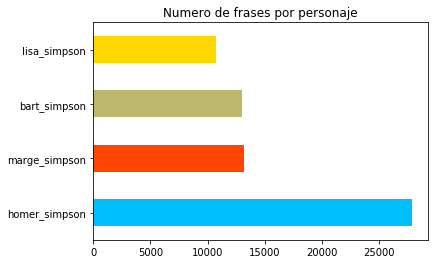

In [8]:
frec = pd.value_counts(labels)
plot = frec.plot(kind='barh',title='Numero de frases por personaje',color=['deepskyblue','orangered','darkkhaki','gold'])

In [9]:
n_lines = frec.values[1]
n_lines

13172

Como se pudo observar en el gráfico anterior y como era de esperar, la cantidad de frases asociadas al personaje Homero es mucho mayor que la de los otros personakes. En consecuencia, se reducirá la cantidad de frases correspondientes a este personaje.

In [10]:
np.random.seed(101)
homer_index = []

for i in range(len(labels)):
  if labels[i] == 'homer_simpson':
    homer_index.append(i)

homer_r = np.random.choice(homer_index,n_lines,replace=False)

In [11]:
np.random.seed(101)
marge_index = []

for i in range(len(labels)):
  if labels[i] == 'marge_simpson':
    marge_index.append(i)

In [12]:
np.random.seed(101)
bart_index = []

for i in range(len(labels)):
  if labels[i] == 'bart_simpson':
    bart_index.append(i)

In [13]:
np.random.seed(101)
lisa_index = []

for i in range(len(labels)):
  if labels[i] == 'lisa_simpson':
    lisa_index.append(i)

In [14]:
sentences = np.array(sentences)
labels = np.array(labels)

homer_s = sentences[homer_r]
marge_s = sentences[marge_index]
bart_s = sentences[bart_index]
lisa_s = sentences[lisa_index]

homer_l = labels[homer_r]
marge_l = labels[marge_index]
bart_l = labels[bart_index]
lisa_l = labels[lisa_index]

In [15]:
homer_s = homer_s.tolist()
marge_s = marge_s.tolist()
bart_s = bart_s.tolist()
lisa_s = lisa_s.tolist()

homer_l = homer_l.tolist()
marge_l = marge_l.tolist()
bart_l = bart_l.tolist()
lisa_l = lisa_l.tolist()

In [16]:
sentences = [homer_s + marge_s + bart_s + lisa_s]
np.shape(sentences)

(1, 50095)

In [17]:
labels = [homer_l + marge_l + bart_l + lisa_l]
np.shape(labels)

(1, 50095)

In [18]:
sentences = sentences[0]
labels = labels[0]

Aquí podremos visualizar la cantidad final de frases correspondientes a cada personaje para el resto de nuestro trabajo. Observemos que las frases del personaje Homero se redujo exactamente a la cantidad de frases asociadas al personaje marge, que corresponde a 13172 frases. También se puede observar que el total de datos con el que vamos a trabajar tiene un tamaño de 50095.

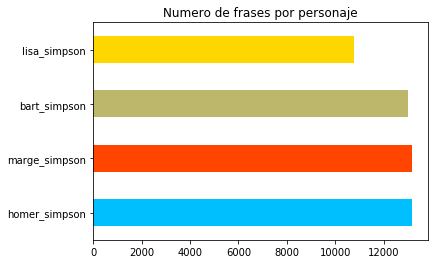

In [19]:
frec = pd.value_counts(labels)
plot = frec.plot(kind='barh',title='Numero de frases por personaje',color=['deepskyblue','orangered','darkkhaki','gold'])

# Separa datos de entrenamiento y validación
### Aleatorización de los datos

In [20]:
# index to sample
n = len(sentences)
sentences = np.array(sentences)
labels = np.array(labels)
np.random.seed(101)
sentences_id  = np.random.permutation(n)
sentences = sentences[sentences_id] 
labels = labels[sentences_id] 

In [21]:
print(sentences[sentences_id] )
print(labels[sentences_id] )

['oh boy free trading cards'
 'well i looked into it and it turns out i was responsible'
 'im practicing my fallout boy dialogue if i get this role i could finally come to terms with this funny little muddle called bart'
 ...
 'excellent now next week is our state of the city address has everyone finalized their proposals'
 'springfield preparatory school dad you told me there were no private schools in springfield'
 'pass']
['bart_simpson' 'bart_simpson' 'bart_simpson' ... 'lisa_simpson'
 'lisa_simpson' 'homer_simpson']


In [22]:
print(labels.shape)
print(sentences.shape)

(50095,)
(50095,)


### Grupo de entrenamiento

Definimos el tamaño de los datos de entrenamiento, que corresponde al 80% de la totalidad de los datos. Definimos "train_sencences" como el conjunto de frases de entrenamiento y "train_labels" como las etiquetas de entrenamiento, las cuales nos serviran como identificadores del conjunto de frases de entrenamiento. En consecuencia, ambos conjuntos contienen el mismo tamaño, el cual es de 40076 datos.

In [23]:
train_size = int(n * training_portion) 

train_sentences = sentences[:train_size]  
train_labels = labels[:train_size] 
print("train_sentences:",len(train_sentences)) 
print("train_labels:",len(train_labels),"\n") 

train_sentences: 40076
train_labels: 40076 



### Grupo de validación

Definimos el tamaño de los datos de validación, que corresponde al 10% de la totalidad de los datos. Definimos "validation_sentences" como el conjunto de frases de validación y "validation_labels" como las etiquetas de validación, las cuales nos serviran como identificadores del conjunto de frases de validación. En consecuencia, ambos conjuntos contienen el mismo tamaño, el cual es de 10019 datos.

In [24]:
validation_sentences = sentences[train_size:] 
validation_labels = labels[train_size:] 
print("validation_sentences:",len(validation_sentences)) 
print("validation_labels:",len(validation_labels),"\n") 

validation_sentences: 10019
validation_labels: 10019 



Aquí podemos ver que la suma entre el conjunto de datos de entrenamiento y el conjunto de datos para validación corresponde efectivamente al total de los datos que se habían considerado para trabajar, cuyo tamaño es de 50095.

In [25]:
print("sentences:",len(sentences))
print("train_sentences + validation_labels:",len(train_sentences)+len(validation_sentences))

sentences: 50095
train_sentences + validation_labels: 50095


# Grafica de frecuencia de n-gramas

Muchas veces estamos interesados en saber que tan frecuente se hace la aparición de una palabra, dos palabras juntas o n palabras juntas. Los n gramas son un tipo de modelo probabilistico, el cual permite hacer una predicción estadística del próximo elemento en este caso, de una cadena de caracteres o palabras, la cual ha sido sucedida hasta el momento. Esto nos permite extraer caracteristicas comúnes de este gran conjunto de texto que estamos utilizando.

### Trigramas

Para cumplir los objetivos de este proyecto, primero juntamos todo el texto en una sola línea y separamos cada palabra con un espacio. Luego formamos un arreglo que contiene cada pa

In [26]:
#Juntamos todo el texto en una sola linea
wordtk = ' '.join(train_sentences)

#Para dividir las frases
tokenstk = regexp_tokenize(wordtk, pattern="\w+")
tokenstk[:10]

['and', 'you', 'will', 'be', 'a', 'dancer', 'hm', 'oh', 'so', 'now']

In [27]:
trigrama = ngrams(tokenstk,3)
trigrama = [' '.join(grams) for grams in trigrama]
trigrama[:5]

['and you will', 'you will be', 'will be a', 'be a dancer', 'a dancer hm']

In [28]:
freq = nltk.FreqDist(trigrama) #frecuencia de los tokens

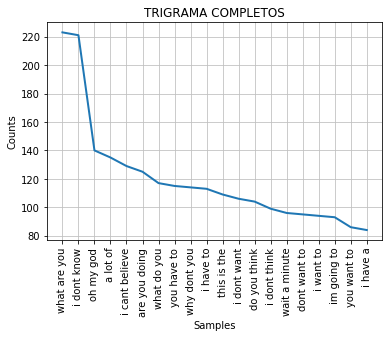

Trigramas completos unicos: 301121


In [29]:
# Gráfica con los trigramas COMPLETOS
freq.plot(20, cumulative=False, title = "TRIGRAMA COMPLETOS")
print("Trigramas completos unicos:", len(freq))

In [30]:
eliminar = [] #filtramos tokens que se repiten mas de una vez
for key,val in freq.items():
  if (200>val>3):
    eliminar.append(str(key))

trigrama_limpio = []
for i in trigrama:
  if i in eliminar:
    trigrama_limpio.append(i)

freqnew = nltk.FreqDist(trigrama_limpio)

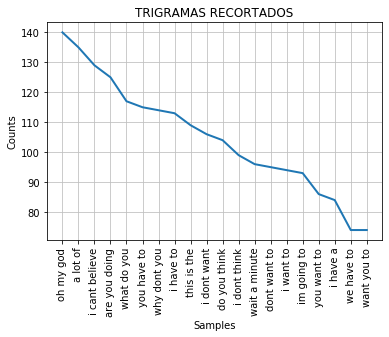

Trigramas recortados unicos: 6149


In [31]:
# Gráfica con los trigramas RECORTADOS
freqnew.plot(20, cumulative=False, title = "TRIGRAMAS RECORTADOS")
print("Trigramas recortados unicos:", len(freqnew))

In [32]:
#comparacion de trigramas
print("Trigramas completos unicos:", len(freq))
print("Trigramas recortados unicos:", len(freqnew))

Trigramas completos unicos: 301121
Trigramas recortados unicos: 6149


### Bigramas

In [33]:
bigrama = ngrams(tokenstk,2)
bigrama = [' '.join(grams) for grams in bigrama]
bigrama[:5]

['and you', 'you will', 'will be', 'be a', 'a dancer']

In [34]:
freqb = nltk.FreqDist(bigrama) #frecuencia de los tokens

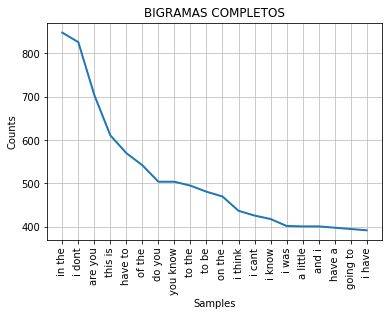

Bigramas completos unicos: 158197


In [35]:
# Gráfica con los bigramas COMPLETOS
freqb.plot(20, cumulative=False, title = "BIGRAMAS COMPLETOS")
print("Bigramas completos unicos:", len(freqb))

In [36]:
eliminarb = [] #filtramos tokens que se repiten mas de una vez
for key,val in freqb.items():
  if (700>val>100):
    eliminarb.append(str(key))

bigrama_limpio = []
for i in bigrama:
  if i in eliminarb:
    bigrama_limpio.append(i)

freqbnew = nltk.FreqDist(bigrama_limpio)

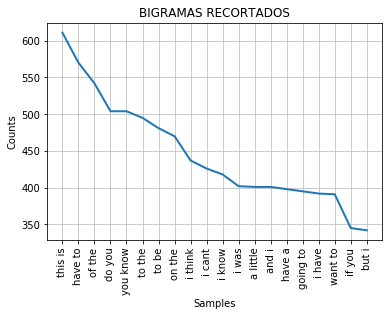

Bigramas recortados unicos: 228


In [37]:
# Gráfica con los Bigramas
freqbnew.plot(20, cumulative=False, title = "BIGRAMAS RECORTADOS")
print("Bigramas recortados unicos:", len(freqbnew))

In [38]:
#comparacion de bigramas
print("Bigramas completos unicos:", len(freqb))
print("Bigramas recortados unicos:", len(freqbnew))

Bigramas completos unicos: 158197
Bigramas recortados unicos: 228


# Vocabulario
### Trigramas

Aunque trigrama_limpio ya no tiene ni los tokens con repitencias muy bajas ni muy altas, contiene tokens repetidos, por eso, para el vocabulario de CountVectorizer utilizameros los freqnew.keys() que contiene los tokens unicos.

In [39]:
vectorizer3 = CountVectorizer(vocabulary=freqnew.keys(), ngram_range=(3,3))

In [40]:
X3 = vectorizer3.fit_transform(train_sentences)
X3

<40076x6149 sparse matrix of type '<class 'numpy.int64'>'
	with 32028 stored elements in Compressed Sparse Row format>

In [41]:
F3 = vectorizer3.get_feature_names() #Mapeo de matriz de índices de enteros a nombres.
F3[:10]

['and you will',
 'will be a',
 'be a dancer',
 'but i dont',
 'i dont think',
 'think it would',
 'whats the matter',
 'the matter with',
 'with you homer',
 'we dont have']

In [42]:
train_sequences = X3.toarray() #arreglo
print("longitud",len(X3.toarray()))

longitud 40076


Como vemos en la tabla, cada fila corresponde a una frase de nuestro __train_sentences__ y cada columna corresponde a un trigrama, por lo tanto la tabla es de (55336 × 8616),

  - train_sentences: 55336
  - Trigramas unicos con sus frecuencias: 8616

In [43]:
pd.DataFrame(train_sequences,columns=vectorizer3.get_feature_names())

,and you will,will be a,be a dancer,but i dont,i dont think,think it would,whats the matter,the matter with,with you homer,we dont have,...,all a part,were number one,old folks home,cheated cheated cheated,shoo shoo shoo,me about the,me i got,gimme the bat,ba ba ba,four score and
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40074,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Bigramas
Aunque bigrama_limpio ya no tiene ni los tokens con repitencias muy bajas ni muy altas, contiene tokens repetidos, por eso, para el vocabulario de CountVectorizer utilizameros los freqbnew.keys() que contiene los tokens unicos.

In [44]:
vectorizer2 = CountVectorizer(vocabulary=freqbnew.keys(), ngram_range=(2,2))

In [45]:
X2 = vectorizer2.fit_transform(train_sentences)
X2

<40076x228 sparse matrix of type '<class 'numpy.int64'>'
	with 28002 stored elements in Compressed Sparse Row format>

In [46]:
F2 = vectorizer2.get_feature_names() #Mapeo de matriz de índices de enteros a nombres.
F2[:10]

['and you',
 'will be',
 'be a',
 'its a',
 'but i',
 'dont think',
 'with you',
 'dont have',
 'i want',
 'want to']

In [47]:
train_sequences_b = X2.toarray() #arreglo
print("longitud",len(X2.toarray()))

longitud 40076


Como vemos en la tabla, cada fila corresponde a una frase de nuestro __train_sentences__ y cada columna corresponde a un bigrama, por lo tanto la tabla es de (55336 × 319),

  - train_sentences: 55336
  - Trigramas unicos con sus frecuencias: 319

In [48]:
pd.DataFrame(train_sequences_b,columns=vectorizer2.get_feature_names())

,and you,will be,be a,its a,but i,dont think,with you,dont have,i want,want to,...,you dont,to me,of your,the way,at least,is it,way to,to take,you i,and the
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40073,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40074,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Datos Entrenamiento
### Juntamos los bigramas y trigramas
Como cada fila corresponde a una frase de nuestro __train_sentences__ y cada columna corresponde a los bigramas y trigramas, nuestra tabla es de (55336 × 9042) donde:

  - train_sentences: 55336
  - Trigramas unicos con sus frecuencias(8616) + bigramas unicos con sus frecuencias(319):  8935

In [49]:
print("Trigramas recortados unicos + Bigramas recortador unicos:", len(freqnew)+len(freqbnew))

Trigramas recortados unicos + Bigramas recortador unicos: 6377


In [50]:
train_sequences_bt = np.concatenate((train_sequences, train_sequences_b), axis=1)
#tamaño de los datos
type(train_sequences_bt)

numpy.ndarray

In [51]:
train_sequences_bt[:5]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [52]:
train_sequences_bt_new = []
train_labels_new = []
for i in range(0,len(train_sequences_bt)):
  if sum(train_sequences_bt[i,]) != 0:
    train_labels_new.append(train_labels[i])
    train_sequences_bt_new.append(train_sequences_bt[i,])

train_sequences_bt = np.array(train_sequences_bt_new)

In [53]:
train_labels = train_labels_new
print("train_sequences_bt",np.shape(train_sequences_bt))
print("train_labels",np.shape(train_labels))

train_sequences_bt (21025, 6377)
train_labels (21025,)


# Datos Validacion
### Trigramas
Las columnas deben coincidir con los trigramas unicos (8616).

In [54]:
X6 = vectorizer3.fit_transform(validation_sentences)
validation_sequences = X6.toarray() #arreglo
print("shape",X6.toarray().shape)

shape (10019, 6149)


### Bigramas
Las columnas deben coincidir con los bigramas unicos (319).

In [55]:
X4 = vectorizer2.fit_transform(validation_sentences)
validation_sequences_b = X4.toarray() #arreglo
print("shape:",X4.toarray().shape)

shape: (10019, 228)


### Juntamos trigramas y bigramas
Vemos que las filas coinciden con numero de frases para validacion y que el numero de columnas (bigramas + trigramas) coindide con el numero de columnas de los datos de entrenamiento,

- train_sentences: 13835
- Trigramas unicos con sus frecuencias(8616) + bigramas unicos con sus frecuencias(319): 8935


In [56]:
validation_sequences_bt = np.concatenate((validation_sequences, validation_sequences_b), axis=1)
#tamaño de los datos
validation_sequences_bt.shape

(10019, 6377)

In [57]:
validation_sequences_bt_new = []
validation_labels_new = []
for i in range(0,len(validation_sequences_bt)):
  if sum(validation_sequences_bt[i,]) != 0:
    validation_labels_new.append(validation_labels[i])
    validation_sequences_bt_new.append(validation_sequences_bt[i,])

validation_sequences_bt = np.array(validation_sequences_bt_new)

In [58]:
validation_labels = validation_labels_new
print(np.shape(validation_sequences_bt))
print(np.shape(validation_labels))

(4879, 6377)
(4879,)


# Labels
### Entrenamiento

In [59]:
label_size = 4
label_tokenizer = Tokenizer(num_words = label_size,oov_token=oov_tok, filters = '')
label_tokenizer.fit_on_texts(train_labels)

label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))

# flatten the nested list and tranaform to an np array
label_seq = np.array([item for items in label_seq for item in items])
training_label_seq = np.array([item for items in training_label_seq for item in items])
training_label_seq[:5]
print(len(training_label_seq))

21025


In [60]:
#Creamos etiquetas numericas
encoder = LabelEncoder()

encoder.fit(label_seq)
train_labels = encoder.transform(training_label_seq)

In [61]:
# Codificación One-Hot 
num_classes = label_size
train_labels_codf = tf.keras.utils.to_categorical(train_labels, num_classes)

In [62]:
len(train_labels_codf)

21025

In [63]:
print(train_labels_codf)

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


### Validacion 

In [64]:
label_size = 4
label_tokenizer = Tokenizer(num_words = label_size,oov_token=oov_tok, filters = '')
label_tokenizer.fit_on_texts(validation_labels)
label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

# flatten the nested list and tranaform to an np array
label_seq = np.array([item for items in label_seq for item in items])
validation_label_seq = np.array([item for items in validation_label_seq for item in items])
validation_label_seq
print(len(validation_label_seq))

4879


In [65]:
#Creamos etiquetas numericas
encoder = LabelEncoder()

encoder.fit(label_seq)
validation_labels = encoder.transform(validation_label_seq)
num_classes = 4

In [66]:
# Codificación One-Hot 
validation_labels_codf = tf.keras.utils.to_categorical(validation_labels, num_classes)

In [67]:
len(validation_labels_codf)

4879

In [68]:
print(validation_labels_codf)

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


# Dividimos test y validación
Recordemos que el grupo de validacion (tanto las frases como los labels) que se ha tenido hasta ahora es el 20% de los datos iniciales, dividiremos este grupo es dos para tomar el 10% del total de los datos iniciales para la validacion interna y el otro 10% para la valicacion externa. Ademas tenga en cuenta que los porcentajes de datos son __aproximados__ debido a la transformacion y limpieza de los datos que se ha hecho.

Tomamos primero los datos de test(validacion externa) y luego los de validacion interna(validation_sequences_bt) porque renombraremos esa variable con el porcentaje de datos especificado arriba.

In [69]:
validation_portion = 0.5
validation_size = int(len(validation_sequences_bt) * validation_portion)
validation_size # 10% del total

test_sequences_bt = validation_sequences_bt[validation_size:] # Frases de test
test_labels_codf = validation_labels_codf[validation_size:] # Etiquetas de test

validation_sequences_bt = validation_sequences_bt[:validation_size] # Frases de validacion 
validation_labels_codf = validation_labels_codf[:validation_size] # Etiquetas de validacion

In [70]:
print(test_labels_codf)

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [71]:
#verificacion de tamaños
print("validation_sequences_bt",validation_sequences_bt.shape) #validacion interna
print("validation_labels_codf",validation_labels_codf.shape)
print("test_sequences_bt",test_sequences_bt.shape) #validacion externa
print("test_labels_codf",test_labels_codf.shape)

validation_sequences_bt (2439, 6377)
validation_labels_codf (2439, 4)
test_sequences_bt (2440, 6377)
test_labels_codf (2440, 4)


# Construccion del Modelo

In [72]:
num_frases_training, num_ngrams, = np.shape(train_sequences_bt)

print("num_frases_training", num_frases_training) #se espera 21025
print("num_ngrams:", num_ngrams) #se espera 6379

num_frases_training 21025
num_ngrams: 6377


In [73]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=10
    )
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

In [75]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(6379, activation='relu', input_shape=(num_ngrams,),
                         activity_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(2440, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6379)              40685262  
_________________________________________________________________
dense_4 (Dense)              (None, 2440)              15567200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2440)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 9764      
Total params: 56,262,226
Trainable params: 56,262,226
Non-trainable params: 0
_________________________________________________________________


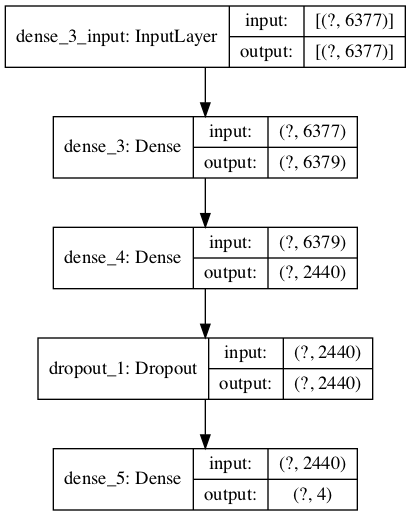

In [78]:
model.summary()
img_path = 'Imagenes'
plot_model(model, to_file=img_path +'clasificacion.png', show_shapes=True)

# Entrenamiento del modelo

|dropout|F. de activación| dense |loss_train |accuracy_train |loss_validation |accuracy_validation |Ephoc|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|4|tanh(1),relu(3)|5|0.7715|0.6028|1.2662|0.4657|7|
|4|tanh(4),relu(1)|6|0.9419|0.5285|1.1128|0.4241|6|
|5|tanh(2),relu(3)|6|0.7683|0.6877|1.7956|0.4490|10|
|5|tanh(0),relu(5)|6|0.4636|0.7820|2.1792|0.4489|10|
|4|tanh(0),relu(5)|6|0.5599|0.7633|1.7796|0.4444|7|
|3|tanh(3),relu(2)|6|0.5243|0.7608|2.0161|0.4381|9|
|4|tanh(5),relu(1)|7|0.9163|0.6148|1.3061|0.4359|5|
|4|tanh(5),relu(1)|7|1.0490|0.5492|1.1830|0.4670|5|
|4|tanh(1),relu(4)|7|0.9413|0.5382|1.0868 |0.4551|8|
|6|tanh(0),relu(7)|8|0.7479|0.6439|1.3333 |0.4498|6|
|1|tanh(0),relu(2)|3|0.5127|0.7513|1.7194 |0.4567|6|


In [ ]:
num_epochs = 10
history = model.fit(train_sequences_bt, train_labels_codf, epochs=num_epochs, validation_data=(validation_sequences_bt,validation_labels_codf),batch_size=32, verbose=True, callbacks=[callback])

print("\nEn la epoca", len(history.history['val_accuracy']), "la precision de validación dejó de mejorar.")

In [ ]:
def plot_graphs(history, string):
  plt.title(string+' con 10 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Prueba del modelo

In [ ]:
#predicciones del modelo
model.predict(test_sequences_bt)

In [ ]:
#etiquetas reales
test_labels_codf

# Funcion clasificadora

In [ ]:
def classifier (sentence): 
  sentence_l = re.sub(' +', ' ',sentence.lower())
  sentence = ''.join(c for c in sentence_l if c in printable)

  X = vectorizer3.fit_transform(sentence) 
  sentences_bt = X3.toarray() #codificacion para tabla con trigramas y bigramas

  prediction = model.predict_classes(sentences_bt)
  prediction = label_tokenizer.sequences_to_texts([prediction])

  return prediction

In [ ]:
classifier('can his funeral be on a school day')